In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 简单的Reranker评估脚本（不做清理）
import re, json
import numpy as np
from collections import Counter

def sigmoid(x):
    """安全的sigmoid函数"""
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

def load_reranker(kind="mini"):
    """加载reranker模型"""
    if kind == "none":
        return None, None
    if kind == "mini":
        from sentence_transformers import CrossEncoder
        model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")
        def predict_fn(pairs):
            raw_scores = model.predict(pairs)
            # 应用sigmoid变换将logits转为概率
            sigmoid_scores = sigmoid(np.array(raw_scores))
            return sigmoid_scores.tolist()
        return predict_fn, "ms-marco-MiniLM"
    elif kind == "bge":
        from FlagEmbedding import FlagReranker
        import torch
        rr = FlagReranker("BAAI/bge-reranker-large", use_fp16=True)
        def predict_fn(pairs):
            scores = rr.compute_score(pairs)
            if isinstance(scores, torch.Tensor):
                scores = scores.sigmoid().tolist()
            else:
                scores = sigmoid(np.array(scores)).tolist()
            return scores
        return predict_fn, "bge-reranker-large"

def extract_question_from_prompt(prompt: str) -> str:
    """从prompt中提取问题"""
    if not isinstance(prompt, str):
        return ""
    m = re.search(r"<\|vision_end\|>(.*)<\|im_end\|>", prompt, re.DOTALL)
    if m:
        q = m.group(1)
    else:
        m2 = re.findall(r"<\|im_start\|>user(.*)<\|im_end\|>", prompt, re.DOTALL)
        q = m2[-1] if m2 else ""
    q = q.replace("\r"," ").replace("\n"," ")
    while "  " in q:
        q = q.replace("  ", " ")
    return q.strip()

def pick_pred(x: dict):
    return x.get("pred") or x.get("prediction") or x.get("output") or x.get("response") or x.get("answer") or x.get("predict")

def pick_gold(x: dict):
    return x.get("gold") or x.get("reference") or x.get("target") or x.get("label") or x.get("answer")

def pick_question(x: dict):
    return x.get("question") or x.get("query") or extract_question_from_prompt(x.get("prompt", ""))

def normalize_text(s: str) -> str:
    if s is None: return ""
    s = s.strip().lower().replace("\u00A0"," ").replace("\t"," ")
    while "  " in s: s = s.replace("  "," ")
    out=[]; i=0
    while i<len(s):
        ch=s[i]
        if ch==',' and i>0 and i+1<len(s) and s[i-1].isdigit() and s[i+1].isdigit():
            i+=1; continue
        out.append(ch); i+=1
    return "".join(out)

def simple_tokenize(s: str):
    s = normalize_text(s)
    return s.split() if s else []

def edit_distance(a: str, b: str) -> int:
    na, nb = len(a), len(b)
    if na==0: return nb
    if nb==0: return na
    prev = list(range(nb+1)); curr=[0]*(nb+1)
    for i in range(1,na+1):
        curr[0]=i; ca=a[i-1]
        for j in range(1,nb+1):
            cb=b[j-1]; cost=0 if ca==cb else 1
            curr[j]=min(prev[j]+1, curr[j-1]+1, prev[j-1]+cost)
        prev, curr = curr, prev
    return prev[nb]

def anls_single(pred: str, gold: str) -> float:
    pred, gold = normalize_text(pred), normalize_text(gold)
    if pred=="" and gold=="": return 1.0
    if pred=="" or gold=="":  return 0.0
    d = edit_distance(pred, gold)
    denom = max(len(pred), len(gold))
    if denom==0: return 0.0
    norm = d/denom
    return (1.0-norm) if norm<0.5 else 0.0

def exact_match(pred: str, gold: str) -> int:
    return int(normalize_text(pred)==normalize_text(gold))

def f1_token_level(pred: str, gold: str) -> float:
    p = simple_tokenize(pred); g = simple_tokenize(gold)
    if not p and not g: return 1.0
    if not p or not g:  return 0.0
    from collections import Counter
    pc, gc = Counter(p), Counter(g)
    overlap = sum((pc & gc).values())
    if overlap==0: return 0.0
    precision, recall = overlap/len(p), overlap/len(g)
    return 2*precision*recall/(precision+recall)

def extract_number(text: str) -> float:
    """从文本中提取数字"""
    if not text:
        return None

    # 处理 thousand, million 等
    text_lower = text.lower()
    multipliers = {
        'thousand': 1000, 'k': 1000,
        'million': 1000000, 'm': 1000000,
        'billion': 1000000000, 'b': 1000000000
    }

    for word, mult in multipliers.items():
        if word in text_lower:
            numbers = re.findall(r'\d+(?:\.\d+)?', text)
            if numbers:
                try:
                    return float(numbers[0]) * mult
                except:
                    pass

    # 提取普通数字
    cleaned = re.sub(r'[,%$]', '', text.strip())
    numbers = re.findall(r'\d+(?:\.\d+)?', cleaned)
    if numbers:
        try:
            return float(numbers[0])
        except:
            return None
    return None

def robust_number_comparison(pred: str, gold: str, tolerance=0.1) -> dict:
    """比较数字预测，允许一定容忍度"""
    pred_num = extract_number(pred)
    gold_num = extract_number(gold)

    result = {
        'pred_num': pred_num,
        'gold_num': gold_num,
        'exact_match': False,
        'close_match': False,
        'relative_error': None
    }

    if pred_num is not None and gold_num is not None:
        if abs(pred_num - gold_num) < 0.001:
            result['exact_match'] = True
            result['close_match'] = True
        elif gold_num > 0:
            rel_error = abs(pred_num - gold_num) / gold_num
            result['relative_error'] = rel_error
            if rel_error <= tolerance:
                result['close_match'] = True

    return result

def evaluate_with_reranker(input_path: str, reranker_kind="mini"):
    """原始预测 + reranker评估（不做清理）"""
    print("=== Evaluating with Reranker (No Cleaning) ===")

    # 加载reranker
    predict_fn, rer_model = load_reranker(reranker_kind) if reranker_kind != "none" else (None, None)

    # 读取数据
    rows = []
    with open(input_path, "r", encoding="utf-8") as f:
        for line in f:
            rows.append(json.loads(line))

    print(f"Total samples: {len(rows)}")

    # 计算所有指标
    anls_list, em_list, f1_list = [], [], []
    numeric_exact_list, numeric_close_list = [], []
    rer_list = []
    pairs = []

    for x in rows:
        pred = pick_pred(x)
        gold = pick_gold(x)
        question = pick_question(x)

        # 传统指标
        anls = anls_single(pred, gold)
        em = exact_match(pred, gold)
        f1 = f1_token_level(pred, gold)

        x['anls'] = anls
        x['em'] = em
        x['f1'] = f1

        anls_list.append(anls)
        em_list.append(em)
        f1_list.append(f1)

        # 数字容忍指标
        num_comp = robust_number_comparison(pred, gold, tolerance=0.15)  # 15%容忍度
        if num_comp['pred_num'] is not None and num_comp['gold_num'] is not None:
            numeric_exact_list.append(1 if num_comp['exact_match'] else 0)
            numeric_close_list.append(1 if num_comp['close_match'] else 0)

        # 为reranker准备数据
        if predict_fn:
            pairs.append((normalize_text(question), normalize_text(pred)))

    # 计算reranker分数
    if predict_fn and pairs:
        print(f"Computing reranker scores for {len(pairs)} pairs...")
        scores = predict_fn(pairs)
        for r, s in zip(rows, scores):
            if isinstance(s, (list, tuple)):
                s = s[0]
            r["reranker_score"] = float(s)
            rer_list.append(float(s))

    # 汇总结果
    metrics = {
        'samples': len(rows),

        # 传统指标
        'anls_mean': np.mean(anls_list),
        'anls_nonzero_coverage': sum(1 for v in anls_list if v > 0) / len(anls_list),
        'em_mean': np.mean(em_list),
        'f1_mean': np.mean(f1_list),

        # 数字容忍指标
        'numeric_samples': len(numeric_exact_list),
        'numeric_exact_accuracy': np.mean(numeric_exact_list) if numeric_exact_list else 0,
        'numeric_close_accuracy_15pct': np.mean(numeric_close_list) if numeric_close_list else 0,

        # reranker指标
        'reranker': reranker_kind,
        'reranker_model': rer_model,
    }

    if rer_list:
        r_sorted = sorted(rer_list)
        metrics.update({
            'reranker_mean': np.mean(rer_list),
            'reranker_min': min(rer_list),
            'reranker_max': max(rer_list),
            'reranker_p50': r_sorted[len(r_sorted)//2],
            'reranker_p90': r_sorted[int(0.9*(len(r_sorted)-1))],
        })

    print("\n=== Final Results ===")
    print(json.dumps(metrics, indent=2))

    # 保存带reranker分数的数据
    output_path = input_path.replace(".jsonl", ".with_reranker.jsonl")
    with open(output_path, "w", encoding="utf-8") as f:
        for row in rows:
            f.write(json.dumps(row, ensure_ascii=False) + "\n")

    metrics_path = input_path.replace(".jsonl", ".final_metrics.json")
    with open(metrics_path, "w", encoding="utf-8") as f:
        json.dump(metrics, f, ensure_ascii=False, indent=2)

    print(f"\nSaved results to: {output_path}")
    print(f"Saved metrics to: {metrics_path}")

    return metrics

# 运行评估
input_file = "/content/drive/MyDrive/llama_saves/Qwen2-VL-2B/lora/infolastest/generated_predictions.jsonl"

# 可以选择不同的reranker: "mini", "bge", 或 "none"
results = evaluate_with_reranker(input_file, reranker_kind="mini")

In [32]:
# 带选项展开的Reranker评估脚本
import re, json
import numpy as np
from collections import Counter

def sigmoid(x):
    """安全的sigmoid函数"""
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

def load_reranker(kind="mini"):
    """加载reranker模型"""
    if kind == "none":
        return None, None
    if kind == "mini":
        from sentence_transformers import CrossEncoder
        model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")
        def predict_fn(pairs):
            raw_scores = model.predict(pairs)
            # 应用sigmoid变换将logits转为概率
            sigmoid_scores = sigmoid(np.array(raw_scores))
            return sigmoid_scores.tolist()
        return predict_fn, "ms-marco-MiniLM"
    elif kind == "bge":
        from FlagEmbedding import FlagReranker
        import torch
        rr = FlagReranker("BAAI/bge-reranker-large", use_fp16=True)
        def predict_fn(pairs):
            scores = rr.compute_score(pairs)
            if isinstance(scores, torch.Tensor):
                scores = scores.sigmoid().tolist()
            else:
                scores = sigmoid(np.array(scores)).tolist()
            return scores
        return predict_fn, "bge-reranker-large"

def extract_options_from_prompt(prompt: str) -> dict:
    """从prompt中提取选项映射"""
    if not isinstance(prompt, str):
        return {}

    options = {}

    # 模式1: A) xxx B) yyy C) zzz
    pattern1 = r'([A-Z])\)\s*([^\n\r]+?)(?=\s*[A-Z]\)|$)'
    matches1 = re.findall(pattern1, prompt, re.MULTILINE)
    for letter, text in matches1:
        options[letter.lower()] = text.strip()
        # 也添加数字映射 A=1, B=2, etc.
        options[str(ord(letter) - ord('A') + 1)] = text.strip()

    # 模式2: 1) xxx 2) yyy 3) zzz
    pattern2 = r'(\d+)\)\s*([^\n\r]+?)(?=\s*\d+\)|$)'
    matches2 = re.findall(pattern2, prompt, re.MULTILINE)
    for num, text in matches2:
        options[num] = text.strip()

    # 模式3: 1. xxx 2. yyy 3. zzz
    pattern3 = r'(\d+)\.\s*([^\n\r]+?)(?=\s*\d+\.|$)'
    matches3 = re.findall(pattern3, prompt, re.MULTILINE)
    for num, text in matches3:
        options[num] = text.strip()

    # 模式4: A. xxx B. yyy C. zzz
    pattern4 = r'([A-Z])\.\s*([^\n\r]+?)(?=\s*[A-Z]\.|$)'
    matches4 = re.findall(pattern4, prompt, re.MULTILINE)
    for letter, text in matches4:
        options[letter.lower()] = text.strip()
        options[str(ord(letter) - ord('A') + 1)] = text.strip()

    # 清理选项文本
    cleaned_options = {}
    for key, value in options.items():
        # 移除前后空白和标点
        clean_value = re.sub(r'^[^\w]*|[^\w]*$', '', value)
        if clean_value and len(clean_value) > 1:  # 至少2个字符
            cleaned_options[key] = clean_value

    return cleaned_options

def is_option_answer(pred: str) -> bool:
    """判断是否是选项答案（单个字母或数字）"""
    pred = pred.strip().lower()
    return bool(re.match(r'^[a-z]$|^\d+$', pred)) and len(pred) <= 2

def expand_prediction(pred: str, prompt: str) -> str:
    """展开预测：如果是选项编号，转换为对应文本"""
    if not is_option_answer(pred):
        return pred

    options = extract_options_from_prompt(prompt)
    pred_clean = pred.strip().lower()

    if pred_clean in options:
        expanded = options[pred_clean]
        print(f"Expanded option: '{pred}' -> '{expanded}'")
        return expanded

    return pred  # 找不到对应选项，返回原值

def extract_question_from_prompt(prompt: str) -> str:
    """从prompt中提取问题"""
    if not isinstance(prompt, str):
        return ""
    m = re.search(r"<\|vision_end\|>(.*)<\|im_end\|>", prompt, re.DOTALL)
    if m:
        q = m.group(1)
    else:
        m2 = re.findall(r"<\|im_start\|>user(.*)<\|im_end\|>", prompt, re.DOTALL)
        q = m2[-1] if m2 else ""
    q = q.replace("\r"," ").replace("\n"," ")
    while "  " in q:
        q = q.replace("  ", " ")
    return q.strip()

def pick_pred(x: dict):
    return x.get("pred") or x.get("prediction") or x.get("output") or x.get("response") or x.get("answer") or x.get("predict")

def pick_gold(x: dict):
    return x.get("gold") or x.get("reference") or x.get("target") or x.get("label") or x.get("answer")

def pick_question(x: dict):
    return x.get("question") or x.get("query") or extract_question_from_prompt(x.get("prompt", ""))

def normalize_text(s: str) -> str:
    if s is None: return ""
    s = s.strip().lower().replace("\u00A0"," ").replace("\t"," ")
    while "  " in s: s = s.replace("  "," ")
    out=[]; i=0
    while i<len(s):
        ch=s[i]
        if ch==',' and i>0 and i+1<len(s) and s[i-1].isdigit() and s[i+1].isdigit():
            i+=1; continue
        out.append(ch); i+=1
    return "".join(out)

def simple_tokenize(s: str):
    s = normalize_text(s)
    return s.split() if s else []

def edit_distance(a: str, b: str) -> int:
    na, nb = len(a), len(b)
    if na==0: return nb
    if nb==0: return na
    prev = list(range(nb+1)); curr=[0]*(nb+1)
    for i in range(1,na+1):
        curr[0]=i; ca=a[i-1]
        for j in range(1,nb+1):
            cb=b[j-1]; cost=0 if ca==cb else 1
            curr[j]=min(prev[j]+1, curr[j-1]+1, prev[j-1]+cost)
        prev, curr = curr, prev
    return prev[nb]

def anls_single(pred: str, gold: str) -> float:
    pred, gold = normalize_text(pred), normalize_text(gold)
    if pred=="" and gold=="": return 1.0
    if pred=="" or gold=="":  return 0.0
    d = edit_distance(pred, gold)
    denom = max(len(pred), len(gold))
    if denom==0: return 0.0
    norm = d/denom
    return (1.0-norm) if norm<0.5 else 0.0

def exact_match(pred: str, gold: str) -> int:
    return int(normalize_text(pred)==normalize_text(gold))

def f1_token_level(pred: str, gold: str) -> float:
    p = simple_tokenize(pred); g = simple_tokenize(gold)
    if not p and not g: return 1.0
    if not p or not g:  return 0.0
    from collections import Counter
    pc, gc = Counter(p), Counter(g)
    overlap = sum((pc & gc).values())
    if overlap==0: return 0.0
    precision, recall = overlap/len(p), overlap/len(g)
    return 2*precision*recall/(precision+recall)

def extract_number(text: str) -> float:
    """从文本中提取数字"""
    if not text:
        return None

    # 处理 thousand, million 等
    text_lower = text.lower()
    multipliers = {
        'thousand': 1000, 'k': 1000,
        'million': 1000000, 'm': 1000000,
        'billion': 1000000000, 'b': 1000000000
    }

    for word, mult in multipliers.items():
        if word in text_lower:
            numbers = re.findall(r'\d+(?:\.\d+)?', text)
            if numbers:
                try:
                    return float(numbers[0]) * mult
                except:
                    pass

    # 提取普通数字
    cleaned = re.sub(r'[,%$]', '', text.strip())
    numbers = re.findall(r'\d+(?:\.\d+)?', cleaned)
    if numbers:
        try:
            return float(numbers[0])
        except:
            return None
    return None

def robust_number_comparison(pred: str, gold: str, tolerance=0.1) -> dict:
    """比较数字预测，允许一定容忍度"""
    pred_num = extract_number(pred)
    gold_num = extract_number(gold)

    result = {
        'pred_num': pred_num,
        'gold_num': gold_num,
        'exact_match': False,
        'close_match': False,
        'relative_error': None
    }

    if pred_num is not None and gold_num is not None:
        if abs(pred_num - gold_num) < 0.001:
            result['exact_match'] = True
            result['close_match'] = True
        elif gold_num > 0:
            rel_error = abs(pred_num - gold_num) / gold_num
            result['relative_error'] = rel_error
            if rel_error <= tolerance:
                result['close_match'] = True

    return result

def evaluate_with_options_and_reranker(input_path: str, reranker_kind="mini", expand_options=True):
    """原始预测 + reranker评估 + 选项展开"""
    print("=== Evaluating with Reranker and Option Expansion ===")

    # 加载reranker
    predict_fn, rer_model = load_reranker(reranker_kind) if reranker_kind != "none" else (None, None)

    # 读取数据
    rows = []
    with open(input_path, "r", encoding="utf-8") as f:
        for line in f:
            rows.append(json.loads(line))

    print(f"Total samples: {len(rows)}")

    # 选项展开
    expanded_count = 0
    if expand_options:
        print("\n=== Expanding Options ===")
        for x in rows:
            original_pred = pick_pred(x)
            prompt = x.get("prompt", "")
            expanded_pred = expand_prediction(original_pred, prompt)

            if expanded_pred != original_pred:
                expanded_count += 1
                x['expanded_pred'] = expanded_pred
            else:
                x['expanded_pred'] = original_pred

        print(f"Expanded {expanded_count} option predictions")

    # 选择使用哪个预测
    def get_final_pred(x: dict):
        if expand_options:
            return x.get('expanded_pred', pick_pred(x))
        else:
            return pick_pred(x)

    # 计算所有指标
    anls_list, em_list, f1_list = [], [], []
    numeric_exact_list, numeric_close_list = [], []
    rer_list = []
    pairs = []

    for x in rows:
        pred = get_final_pred(x)
        gold = pick_gold(x)
        question = pick_question(x)

        # 传统指标
        anls = anls_single(pred, gold)
        em = exact_match(pred, gold)
        f1 = f1_token_level(pred, gold)

        x['final_anls'] = anls
        x['final_em'] = em
        x['final_f1'] = f1

        anls_list.append(anls)
        em_list.append(em)
        f1_list.append(f1)

        # 数字容忍指标
        num_comp = robust_number_comparison(pred, gold, tolerance=0.15)  # 15%容忍度
        if num_comp['pred_num'] is not None and num_comp['gold_num'] is not None:
            numeric_exact_list.append(1 if num_comp['exact_match'] else 0)
            numeric_close_list.append(1 if num_comp['close_match'] else 0)

        # 为reranker准备数据
        if predict_fn:
            pairs.append((normalize_text(question), normalize_text(pred)))

    # 计算reranker分数
    if predict_fn and pairs:
        print(f"Computing reranker scores for {len(pairs)} pairs...")
        scores = predict_fn(pairs)
        for r, s in zip(rows, scores):
            if isinstance(s, (list, tuple)):
                s = s[0]
            r["reranker_score"] = float(s)
            rer_list.append(float(s))

    # 汇总结果
    metrics = {
        'samples': len(rows),
        'option_expansion_enabled': expand_options,
        'expanded_predictions': expanded_count if expand_options else 0,

        # 传统指标
        'anls_mean': np.mean(anls_list),
        'anls_nonzero_coverage': sum(1 for v in anls_list if v > 0) / len(anls_list),
        'em_mean': np.mean(em_list),
        'f1_mean': np.mean(f1_list),

        # 对比原始结果
        'original_anls_mean': 0.1307216229894276,
        'original_em_mean': 0.07663551401869159,
        'original_f1_mean': 0.20578810146419727,
        'anls_improvement': np.mean(anls_list) - 0.1307216229894276,
        'em_improvement': np.mean(em_list) - 0.07663551401869159,
        'f1_improvement': np.mean(f1_list) - 0.20578810146419727,

        # 数字容忍指标
        'numeric_samples': len(numeric_exact_list),
        'numeric_exact_accuracy': np.mean(numeric_exact_list) if numeric_exact_list else 0,
        'numeric_close_accuracy_15pct': np.mean(numeric_close_list) if numeric_close_list else 0,

        # reranker指标
        'reranker': reranker_kind,
        'reranker_model': rer_model,
    }

    if rer_list:
        r_sorted = sorted(rer_list)
        metrics.update({
            'reranker_mean': np.mean(rer_list),
            'reranker_min': min(rer_list),
            'reranker_max': max(rer_list),
            'reranker_p50': r_sorted[len(r_sorted)//2],
            'reranker_p90': r_sorted[int(0.9*(len(r_sorted)-1))],
            'original_reranker_mean': 0.10125948500048355,
            'reranker_improvement': np.mean(rer_list) - 0.10125948500048355,
        })

    print("\n=== Final Results ===")
    print(json.dumps(metrics, indent=2))

    # 保存结果
    output_path = input_path.replace(".jsonl", ".final_with_options.jsonl")
    with open(output_path, "w", encoding="utf-8") as f:
        for row in rows:
            f.write(json.dumps(row, ensure_ascii=False) + "\n")

    metrics_path = input_path.replace(".jsonl", ".final_metrics_with_options.json")
    with open(metrics_path, "w", encoding="utf-8") as f:
        json.dump(metrics, f, ensure_ascii=False, indent=2)

    print(f"\nSaved results to: {output_path}")
    print(f"Saved metrics to: {metrics_path}")

    return metrics

# 运行评估（包含选项展开）
input_file = "/content/drive/MyDrive/llama_saves/Qwen2-VL-2B/lora/infolastest/generated_predictions.jsonl"

# 可以选择不同的reranker: "mini", "bge", 或 "none"
# expand_options=True 会将 1/2/3 转换为对应的选项文本
results = evaluate_with_options_and_reranker(input_file, reranker_kind="mini", expand_options=True)

=== Evaluating with Reranker and Option Expansion ===
Total samples: 535

=== Expanding Options ===
Expanded 0 option predictions
Computing reranker scores for 535 pairs...

=== Final Results ===
{
  "samples": 535,
  "option_expansion_enabled": true,
  "expanded_predictions": 0,
  "anls_mean": 0.0990085488423102,
  "anls_nonzero_coverage": 0.11962616822429907,
  "em_mean": 0.05420560747663551,
  "f1_mean": 0.1781307748654733,
  "original_anls_mean": 0.1307216229894276,
  "original_em_mean": 0.07663551401869159,
  "original_f1_mean": 0.20578810146419727,
  "anls_improvement": -0.03171307414711741,
  "em_improvement": -0.02242990654205608,
  "f1_improvement": -0.02765732659872397,
  "numeric_samples": 295,
  "numeric_exact_accuracy": 0.19661016949152543,
  "numeric_close_accuracy_15pct": 0.27796610169491526,
  "reranker": "mini",
  "reranker_model": "ms-marco-MiniLM",
  "reranker_mean": 0.13573839569559493,
  "reranker_min": 1.0896051207964774e-05,
  "reranker_max": 0.9999300241470337,


vblora on vqa

In [37]:
import json
import re
import numpy as np
from collections import Counter

def sigmoid(x):
    """安全的sigmoid函数"""
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

def load_reranker(kind="mini"):
    """加载reranker模型"""
    if kind == "none":
        return None, None
    if kind == "mini":
        from sentence_transformers import CrossEncoder
        model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")
        def predict_fn(pairs):
            raw_scores = model.predict(pairs)
            sigmoid_scores = sigmoid(np.array(raw_scores))
            return sigmoid_scores.tolist()
        return predict_fn, "ms-marco-MiniLM"
    elif kind == "bge":
        from FlagEmbedding import FlagReranker
        import torch
        rr = FlagReranker("BAAI/bge-reranker-large", use_fp16=True)
        def predict_fn(pairs):
            scores = rr.compute_score(pairs)
            if isinstance(scores, torch.Tensor):
                scores = scores.sigmoid().tolist()
            else:
                scores = sigmoid(np.array(scores)).tolist()
            return scores
        return predict_fn, "bge-reranker-large"

def extract_keywords_from_prediction(prediction: str, top_n=5) -> str:
    """从冗长的预测中提取关键词"""
    if not prediction:
        return ""

    # 1. 清理文本
    text = prediction.lower()

    # 2. 移除重复的句子片段
    sentences = re.split(r'[.!?]\s*', text)
    unique_sentences = []
    seen = set()
    for sent in sentences:
        sent = sent.strip()
        if sent and sent not in seen and len(sent) > 10:
            seen.add(sent)
            unique_sentences.append(sent)

    # 3. 提取候选关键词
    candidates = []

    # 方法1: 提取开头的词汇（通常是答案）
    first_words = re.findall(r'\b[a-zA-Z]+\b', prediction[:200])
    candidates.extend(first_words[:10])

    # 方法2: 提取品牌/平台名称
    platform_keywords = [
        'pinterest', 'facebook', 'instagram', 'linkedin', 'twitter',
        'youtube', 'tiktok', 'snapchat', 'whatsapp', 'telegram',
        'restaurants', 'interior design', 'wedding venues', 'fashion',
        'food', 'travel', 'photography', 'art', 'design', 'business',
        'home', 'decor', 'style', 'beauty', 'fitness', 'health'
    ]

    for keyword in platform_keywords:
        if keyword in text:
            candidates.append(keyword)

    # 方法3: 提取逗号分隔的词汇
    comma_separated = re.findall(r'\b[a-zA-Z\s]+(?=,|\.|$)', text[:300])
    for item in comma_separated:
        item = item.strip()
        if item and len(item.split()) <= 3:  # 最多3个词
            candidates.append(item)

    # 4. 统计词频并选择最佳答案
    word_counts = Counter()
    for candidate in candidates:
        if candidate and len(candidate) > 1:
            clean_candidate = re.sub(r'[^\w\s,]', '', candidate).strip()
            if clean_candidate:
                word_counts[clean_candidate] += 1

    # 5. 选择最频繁的关键词
    if word_counts:
        # 优先选择平台关键词
        for keyword in platform_keywords:
            if keyword in word_counts:
                return keyword

        # 否则选择最频繁的词
        most_common = word_counts.most_common(top_n)
        best_candidates = [word for word, count in most_common if count >= 1]

        if best_candidates:
            return ', '.join(best_candidates[:3])  # 最多3个关键词

    # 6. 如果都失败，返回前几个有意义的词
    words = re.findall(r'\b[a-zA-Z]+\b', prediction[:100])
    meaningful_words = [w for w in words if len(w) > 2 and w.lower() not in
                       ['the', 'and', 'for', 'are', 'this', 'that', 'with', 'have', 'will']]

    if meaningful_words:
        return ', '.join(meaningful_words[:3])

    return prediction[:50].strip()  # 最后的备选方案

def extract_question_from_prompt(prompt: str) -> str:
    """从prompt中提取问题"""
    if not isinstance(prompt, str):
        return ""
    m = re.search(r"<\|vision_end\|>(.*)<\|im_end\|>", prompt, re.DOTALL)
    if m:
        q = m.group(1)
    else:
        m2 = re.findall(r"<\|im_start\|>user(.*)<\|im_end\|>", prompt, re.DOTALL)
        q = m2[-1] if m2 else ""
    q = q.replace("\r"," ").replace("\n"," ")
    while "  " in q:
        q = q.replace("  ", " ")
    return q.strip()

def normalize_text(s: str) -> str:
    if s is None: return ""
    s = str(s).strip().lower().replace("\u00A0"," ").replace("\t"," ")
    while "  " in s: s = s.replace("  "," ")
    return s

def simple_tokenize(s: str):
    s = normalize_text(s)
    return s.split() if s else []

def edit_distance(a: str, b: str) -> int:
    na, nb = len(a), len(b)
    if na==0: return nb
    if nb==0: return na
    prev = list(range(nb+1)); curr=[0]*(nb+1)
    for i in range(1,na+1):
        curr[0]=i; ca=a[i-1]
        for j in range(1,nb+1):
            cb=b[j-1]; cost=0 if ca==cb else 1
            curr[j]=min(prev[j]+1, curr[j-1]+1, prev[j-1]+cost)
        prev, curr = curr, prev
    return prev[nb]

def anls_single(pred: str, gold: str) -> float:
    pred, gold = normalize_text(pred), normalize_text(gold)
    if pred=="" and gold=="": return 1.0
    if pred=="" or gold=="":  return 0.0
    d = edit_distance(pred, gold)
    denom = max(len(pred), len(gold))
    if denom==0: return 0.0
    norm = d/denom
    return (1.0-norm) if norm<0.5 else 0.0

def exact_match(pred: str, gold: str) -> int:
    return int(normalize_text(pred) == normalize_text(gold))

def f1_token_level(pred: str, gold: str) -> float:
    p = simple_tokenize(pred); g = simple_tokenize(gold)
    if not p and not g: return 1.0
    if not p or not g:  return 0.0

    pc, gc = Counter(p), Counter(g)
    overlap = sum((pc & gc).values())
    if overlap==0: return 0.0
    precision, recall = overlap/len(p), overlap/len(g)
    return 2*precision*recall/(precision+recall)

def comprehensive_evaluate_with_cleaning_and_reranker(input_path: str, reranker_kind="mini", cleaning_threshold=200):
    """整合清理和reranker的综合评估"""
    print("=== Comprehensive Evaluation: Cleaning + Reranker ===")

    # 加载reranker
    predict_fn, rer_model = load_reranker(reranker_kind) if reranker_kind != "none" else (None, None)

    # 读取数据
    print(f"Loading data from: {input_path}")
    rows = []
    with open(input_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                rows.append(json.loads(line))

    print(f"Total samples: {len(rows)}")

    # === 第一步：清理预测 ===
    print(f"\n=== Step 1: Cleaning Predictions ===")
    cleaned_count = 0
    for i, row in enumerate(rows):
        original_pred = row.get('predict', '')

        if len(original_pred) > cleaning_threshold:
            cleaned_pred = extract_keywords_from_prediction(original_pred)
            row['cleaned_predict'] = cleaned_pred
            row['original_predict_length'] = len(original_pred)
            cleaned_count += 1

            # 显示前几个清理示例
            if i < 3:
                print(f"\nSample {i}:")
                print(f"  Original: {original_pred[:100]}...")
                print(f"  Cleaned:  {cleaned_pred}")
                print(f"  Gold:     {row.get('label', '')}")
        else:
            row['cleaned_predict'] = original_pred
            row['original_predict_length'] = len(original_pred)

    print(f"Cleaned {cleaned_count} long predictions (>{cleaning_threshold} chars)")

    # === 第二步：计算传统指标 ===
    print(f"\n=== Step 2: Computing Traditional Metrics ===")

    # 原始预测指标
    original_anls_list, original_em_list, original_f1_list = [], [], []
    # 清理后预测指标
    cleaned_anls_list, cleaned_em_list, cleaned_f1_list = [], [], []

    improvement_cases = []

    for row in rows:
        original_pred = row.get('predict', '')
        cleaned_pred = row.get('cleaned_predict', '')
        gold = row.get('label', '')

        # 原始指标
        orig_anls = anls_single(original_pred, gold)
        orig_em = exact_match(original_pred, gold)
        orig_f1 = f1_token_level(original_pred, gold)

        # 清理后指标
        clean_anls = anls_single(cleaned_pred, gold)
        clean_em = exact_match(cleaned_pred, gold)
        clean_f1 = f1_token_level(cleaned_pred, gold)

        # 保存到row中
        row['original_anls'] = orig_anls
        row['original_em'] = orig_em
        row['original_f1'] = orig_f1
        row['cleaned_anls'] = clean_anls
        row['cleaned_em'] = clean_em
        row['cleaned_f1'] = clean_f1

        original_anls_list.append(orig_anls)
        original_em_list.append(orig_em)
        original_f1_list.append(orig_f1)
        cleaned_anls_list.append(clean_anls)
        cleaned_em_list.append(clean_em)
        cleaned_f1_list.append(clean_f1)

        # 记录改进案例
        if clean_em > orig_em or clean_f1 > orig_f1:
            improvement_cases.append({
                'original': original_pred[:80],
                'cleaned': cleaned_pred,
                'gold': gold,
                'orig_em': orig_em,
                'clean_em': clean_em,
                'orig_f1': orig_f1,
                'clean_f1': clean_f1
            })

    # === 第三步：计算Reranker分数 ===
    print(f"\n=== Step 3: Computing Reranker Scores ===")

    original_rer_list = []
    cleaned_rer_list = []

    if predict_fn:
        # 准备原始预测的pairs
        original_pairs = []
        cleaned_pairs = []

        for row in rows:
            question = extract_question_from_prompt(row.get('prompt', ''))
            original_pred = row.get('predict', '')
            cleaned_pred = row.get('cleaned_predict', '')

            if question and original_pred:
                original_pairs.append((normalize_text(question), normalize_text(original_pred)))
            if question and cleaned_pred:
                cleaned_pairs.append((normalize_text(question), normalize_text(cleaned_pred)))

        print(f"Computing reranker scores for {len(original_pairs)} original pairs...")
        try:
            original_scores = predict_fn(original_pairs)
            for i, (row, score) in enumerate(zip(rows[:len(original_scores)], original_scores)):
                if isinstance(score, (list, tuple)):
                    score = score[0] if score else 0.0
                row['original_reranker_score'] = float(score)
                original_rer_list.append(float(score))
        except Exception as e:
            print(f"Original reranker computation failed: {e}")

        print(f"Computing reranker scores for {len(cleaned_pairs)} cleaned pairs...")
        try:
            cleaned_scores = predict_fn(cleaned_pairs)
            for i, (row, score) in enumerate(zip(rows[:len(cleaned_scores)], cleaned_scores)):
                if isinstance(score, (list, tuple)):
                    score = score[0] if score else 0.0
                row['cleaned_reranker_score'] = float(score)
                cleaned_rer_list.append(float(score))
        except Exception as e:
            print(f"Cleaned reranker computation failed: {e}")

    # === 第四步：汇总结果 ===
    print(f"\n=== Step 4: Results Summary ===")

    metrics = {
        'total_samples': len(rows),
        'cleaned_predictions': cleaned_count,
        'cleaning_threshold': cleaning_threshold,

        # 传统指标对比
        'original_anls_mean': np.mean(original_anls_list),
        'cleaned_anls_mean': np.mean(cleaned_anls_list),
        'anls_improvement': np.mean(cleaned_anls_list) - np.mean(original_anls_list),

        'original_em_mean': np.mean(original_em_list),
        'cleaned_em_mean': np.mean(cleaned_em_list),
        'em_improvement': np.mean(cleaned_em_list) - np.mean(original_em_list),

        'original_f1_mean': np.mean(original_f1_list),
        'cleaned_f1_mean': np.mean(cleaned_f1_list),
        'f1_improvement': np.mean(cleaned_f1_list) - np.mean(original_f1_list),

        'improved_cases': len(improvement_cases),

        # Reranker指标
        'reranker_model': rer_model,
    }

    if original_rer_list:
        metrics.update({
            'original_reranker_mean': np.mean(original_rer_list),
            'original_reranker_std': np.std(original_rer_list),
        })

    if cleaned_rer_list:
        metrics.update({
            'cleaned_reranker_mean': np.mean(cleaned_rer_list),
            'cleaned_reranker_std': np.std(cleaned_rer_list),
            'reranker_improvement': np.mean(cleaned_rer_list) - np.mean(original_rer_list) if original_rer_list else 0,
        })

    # 显示结果
    print("Results:")
    print(f"  Original ANLS: {metrics['original_anls_mean']:.4f}")
    print(f"  Cleaned ANLS:  {metrics['cleaned_anls_mean']:.4f}")
    print(f"  ANLS Improvement: {metrics['anls_improvement']:.4f}")
    print(f"  Original EM: {metrics['original_em_mean']:.4f}")
    print(f"  Cleaned EM:  {metrics['cleaned_em_mean']:.4f}")
    print(f"  EM Improvement: {metrics['em_improvement']:.4f}")
    print(f"  Original F1: {metrics['original_f1_mean']:.4f}")
    print(f"  Cleaned F1:  {metrics['cleaned_f1_mean']:.4f}")
    print(f"  F1 Improvement: {metrics['f1_improvement']:.4f}")

    if original_rer_list and cleaned_rer_list:
        print(f"  Original Reranker: {metrics['original_reranker_mean']:.4f}")
        print(f"  Cleaned Reranker:  {metrics['cleaned_reranker_mean']:.4f}")
        print(f"  Reranker Improvement: {metrics['reranker_improvement']:.4f}")

    print(f"  Improved cases: {metrics['improved_cases']}")

    # 显示改进案例
    print(f"\n=== Top Improvement Cases ===")
    for i, case in enumerate(improvement_cases[:3]):
        print(f"Case {i+1}:")
        print(f"  Original: {case['original']}...")
        print(f"  Cleaned:  {case['cleaned']}")
        print(f"  Gold:     {case['gold']}")
        print(f"  EM: {case['orig_em']} -> {case['clean_em']}")
        print(f"  F1: {case['orig_f1']:.3f} -> {case['clean_f1']:.3f}")
        print()

    # === 保存结果 ===
    output_path = input_path.replace('.jsonl', '_comprehensive_results.jsonl')
    with open(output_path, 'w', encoding='utf-8') as f:
        for row in rows:
            f.write(json.dumps(row, ensure_ascii=False) + '\n')

    metrics_path = input_path.replace('.jsonl', '_comprehensive_metrics.json')
    with open(metrics_path, 'w', encoding='utf-8') as f:
        json.dump(metrics, f, ensure_ascii=False, indent=2)

    print(f"\nSaved detailed results to: {output_path}")
    print(f"Saved metrics to: {metrics_path}")

    return metrics

if __name__ == "__main__":
    # 运行综合评估
    input_file = "/content/drive/MyDrive/llama_saves/Qwen2-VL-2B/lora/infovblastest/generated_predictions.jsonl"

    # 参数说明：
    # reranker_kind: "mini", "bge", 或 "none"
    # cleaning_threshold: 超过这个字符数的预测会被清理，默认200
    results = comprehensive_evaluate_with_cleaning_and_reranker(
        input_file,
        reranker_kind="bge",
        cleaning_threshold=200
    )

=== Comprehensive Evaluation: Cleaning + Reranker ===


tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Loading data from: /content/drive/MyDrive/llama_saves/Qwen2-VL-2B/lora/infovblastest/generated_predictions.jsonl
Total samples: 535

=== Step 1: Cleaning Predictions ===

Sample 0:
  Original: Pinterest Pinterest, Pinterest, Pinterest[2] Pinterest, Pinterest, Pinterest is a social media platf...
  Cleaned:  pinterest
  Gold:     pinterest


Sample 1:
  Original: Rest: Social media platform cheat sheet, Social media platform cheat sheet, Retail, Nonprofits, News...
  Cleaned:  Social, media, platform
  Gold:     restaurants, interior design, wedding venues


Sample 2:
  Original: Facebook, Instagram, Instagram, Instagram is good for B2B companies, Instagram, Instagram is good fo...
  Cleaned:  facebook
  Gold:     linkedin, facebook

Cleaned 126 long predictions (>200 chars)

=== Step 2: Computing Traditional Metrics ===

=== Step 3: Computing Reranker Scores ===
Computing reranker scores for 469 original pairs...


Compute Scores: 100%|██████████| 4/4 [00:00<00:00, 22.92it/s]


Computing reranker scores for 469 cleaned pairs...


Compute Scores: 100%|██████████| 4/4 [00:00<00:00, 21.02it/s]



=== Step 4: Results Summary ===
Results:
  Original ANLS: 0.0015
  Cleaned ANLS:  0.0344
  ANLS Improvement: 0.0329
  Original EM: 0.0000
  Cleaned EM:  0.0187
  EM Improvement: 0.0187
  Original F1: 0.0344
  Cleaned F1:  0.0648
  F1 Improvement: 0.0304
  Original Reranker: 0.3394
  Cleaned Reranker:  0.2676
  Reranker Improvement: -0.0718
  Improved cases: 38

=== Top Improvement Cases ===
Case 1:
  Original: Pinterest Pinterest, Pinterest, Pinterest[2] Pinterest, Pinterest, Pinterest is ...
  Cleaned:  pinterest
  Gold:     pinterest

  EM: 0 -> 1
  F1: 0.059 -> 1.000

Case 2:
  Original: Facebook, Instagram, Instagram, Instagram is good for B2B companies, Instagram, ...
  Cleaned:  facebook
  Gold:     linkedin, facebook

  EM: 0 -> 0
  F1: 0.061 -> 0.667

Case 3:
  Original: LinkedIn, LinkedIn, LinkedIn, LinkedInthe platform, LinkedIn, LinkedIn, LinkedIn...
  Cleaned:  linkedin
  Gold:     linkedin

  EM: 0 -> 1
  F1: 0.077 -> 1.000


Saved detailed results to: /content/drive/MyDr

In [47]:
import json
import re
import numpy as np
from collections import Counter

def sigmoid(x):
    """安全的sigmoid函数"""
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

def load_reranker(kind="mini"):
    """加载reranker模型"""
    if kind == "none":
        return None, None
    if kind == "mini":
        from sentence_transformers import CrossEncoder
        model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")
        def predict_fn(pairs):
            raw_scores = model.predict(pairs)
            sigmoid_scores = sigmoid(np.array(raw_scores))
            return sigmoid_scores.tolist()
        return predict_fn, "ms-marco-MiniLM"
    elif kind == "bge":
        from FlagEmbedding import FlagReranker
        import torch
        rr = FlagReranker("BAAI/bge-reranker-large", use_fp16=True)
        def predict_fn(pairs):
            scores = rr.compute_score(pairs)
            if isinstance(scores, torch.Tensor):
                scores = scores.sigmoid().tolist()
            else:
                scores = sigmoid(np.array(scores)).tolist()
            return scores
        return predict_fn, "bge-reranker-large"

def extract_keywords_from_prediction(prediction: str, top_n=5) -> str:
    """从冗长的预测中提取关键词"""
    if not prediction:
        return ""

    # 1. 清理文本
    text = prediction.lower()

    # 2. 移除重复的句子片段
    sentences = re.split(r'[.!?]\s*', text)
    unique_sentences = []
    seen = set()
    for sent in sentences:
        sent = sent.strip()
        if sent and sent not in seen and len(sent) > 10:
            seen.add(sent)
            unique_sentences.append(sent)

    # 3. 提取候选关键词
    candidates = []

    # 方法1: 提取开头的词汇（通常是答案）
    first_words = re.findall(r'\b[a-zA-Z]+\b', prediction[:200])
    candidates.extend(first_words[:10])

    # 方法2: 提取品牌/平台名称
    platform_keywords = [
        'pinterest', 'facebook', 'instagram', 'linkedin', 'twitter',
        'youtube', 'tiktok', 'snapchat', 'whatsapp', 'telegram',
        'restaurants', 'interior design', 'wedding venues', 'fashion',
        'food', 'travel', 'photography', 'art', 'design', 'business',
        'home', 'decor', 'style', 'beauty', 'fitness', 'health'
    ]

    for keyword in platform_keywords:
        if keyword in text:
            candidates.append(keyword)

    # 方法3: 提取逗号分隔的词汇
    comma_separated = re.findall(r'\b[a-zA-Z\s]+(?=,|\.|$)', text[:300])
    for item in comma_separated:
        item = item.strip()
        if item and len(item.split()) <= 3:  # 最多3个词
            candidates.append(item)

    # 4. 统计词频并选择最佳答案
    word_counts = Counter()
    for candidate in candidates:
        if candidate and len(candidate) > 1:
            clean_candidate = re.sub(r'[^\w\s,]', '', candidate).strip()
            if clean_candidate:
                word_counts[clean_candidate] += 1

    # 5. 选择最频繁的关键词
    if word_counts:
        # 优先选择平台关键词
        for keyword in platform_keywords:
            if keyword in word_counts:
                return keyword

        # 否则选择最频繁的词
        most_common = word_counts.most_common(top_n)
        best_candidates = [word for word, count in most_common if count >= 1]

        if best_candidates:
            return ', '.join(best_candidates[:3])  # 最多3个关键词

    # 6. 如果都失败，返回前几个有意义的词
    words = re.findall(r'\b[a-zA-Z]+\b', prediction[:100])
    meaningful_words = [w for w in words if len(w) > 2 and w.lower() not in
                       ['the', 'and', 'for', 'are', 'this', 'that', 'with', 'have', 'will']]

    if meaningful_words:
        return ', '.join(meaningful_words[:3])

    return prediction[:50].strip()  # 最后的备选方案

def extract_question_from_prompt(prompt: str) -> str:
    """从prompt中提取问题"""
    if not isinstance(prompt, str):
        return ""
    m = re.search(r"<\|vision_end\|>(.*)<\|im_end\|>", prompt, re.DOTALL)
    if m:
        q = m.group(1)
    else:
        m2 = re.findall(r"<\|im_start\|>user(.*)<\|im_end\|>", prompt, re.DOTALL)
        q = m2[-1] if m2 else ""
    q = q.replace("\r"," ").replace("\n"," ")
    while "  " in q:
        q = q.replace("  ", " ")
    return q.strip()

def normalize_text(s: str) -> str:
    if s is None: return ""
    s = str(s).strip().lower().replace("\u00A0"," ").replace("\t"," ")
    while "  " in s: s = s.replace("  "," ")
    return s

def simple_tokenize(s: str):
    s = normalize_text(s)
    return s.split() if s else []

def edit_distance(a: str, b: str) -> int:
    na, nb = len(a), len(b)
    if na==0: return nb
    if nb==0: return na
    prev = list(range(nb+1)); curr=[0]*(nb+1)
    for i in range(1,na+1):
        curr[0]=i; ca=a[i-1]
        for j in range(1,nb+1):
            cb=b[j-1]; cost=0 if ca==cb else 1
            curr[j]=min(prev[j]+1, curr[j-1]+1, prev[j-1]+cost)
        prev, curr = curr, prev
    return prev[nb]

def anls_single(pred: str, gold: str) -> float:
    pred, gold = normalize_text(pred), normalize_text(gold)
    if pred=="" and gold=="": return 1.0
    if pred=="" or gold=="":  return 0.0
    d = edit_distance(pred, gold)
    denom = max(len(pred), len(gold))
    if denom==0: return 0.0
    norm = d/denom
    return (1.0-norm) if norm<0.5 else 0.0

def exact_match(pred: str, gold: str) -> int:
    return int(normalize_text(pred) == normalize_text(gold))

def f1_token_level(pred: str, gold: str) -> float:
    p = simple_tokenize(pred); g = simple_tokenize(gold)
    if not p and not g: return 1.0
    if not p or not g:  return 0.0

    pc, gc = Counter(p), Counter(g)
    overlap = sum((pc & gc).values())
    if overlap==0: return 0.0
    precision, recall = overlap/len(p), overlap/len(g)
    return 2*precision*recall/(precision+recall)

def comprehensive_evaluate_with_cleaning_and_reranker(input_path: str, reranker_kind="mini", cleaning_threshold=200):
    """整合清理和reranker的综合评估"""
    print("=== Comprehensive Evaluation: Cleaning + Reranker ===")

    # 加载reranker
    predict_fn, rer_model = load_reranker(reranker_kind) if reranker_kind != "none" else (None, None)

    # 读取数据
    print(f"Loading data from: {input_path}")
    rows = []
    with open(input_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                rows.append(json.loads(line))

    print(f"Total samples: {len(rows)}")

    # === 第一步：清理预测 ===
    print(f"\n=== Step 1: Cleaning Predictions ===")
    cleaned_count = 0
    for i, row in enumerate(rows):
        original_pred = row.get('predict', '')

        if len(original_pred) > cleaning_threshold:
            cleaned_pred = extract_keywords_from_prediction(original_pred)
            row['cleaned_predict'] = cleaned_pred
            row['original_predict_length'] = len(original_pred)
            cleaned_count += 1

            # 显示前几个清理示例
            if i < 3:
                print(f"\nSample {i}:")
                print(f"  Original: {original_pred[:100]}...")
                print(f"  Cleaned:  {cleaned_pred}")
                print(f"  Gold:     {row.get('label', '')}")
        else:
            row['cleaned_predict'] = original_pred
            row['original_predict_length'] = len(original_pred)

    print(f"Cleaned {cleaned_count} long predictions (>{cleaning_threshold} chars)")

    # === 第二步：计算传统指标 ===
    print(f"\n=== Step 2: Computing Traditional Metrics ===")

    # 原始预测指标
    original_anls_list, original_em_list, original_f1_list = [], [], []
    # 清理后预测指标
    cleaned_anls_list, cleaned_em_list, cleaned_f1_list = [], [], []

    improvement_cases = []

    for row in rows:
        original_pred = row.get('predict', '')
        cleaned_pred = row.get('cleaned_predict', '')
        gold = row.get('label', '')

        # 原始指标
        orig_anls = anls_single(original_pred, gold)
        orig_em = exact_match(original_pred, gold)
        orig_f1 = f1_token_level(original_pred, gold)

        # 清理后指标
        clean_anls = anls_single(cleaned_pred, gold)
        clean_em = exact_match(cleaned_pred, gold)
        clean_f1 = f1_token_level(cleaned_pred, gold)

        # 保存到row中
        row['original_anls'] = orig_anls
        row['original_em'] = orig_em
        row['original_f1'] = orig_f1
        row['cleaned_anls'] = clean_anls
        row['cleaned_em'] = clean_em
        row['cleaned_f1'] = clean_f1

        original_anls_list.append(orig_anls)
        original_em_list.append(orig_em)
        original_f1_list.append(orig_f1)
        cleaned_anls_list.append(clean_anls)
        cleaned_em_list.append(clean_em)
        cleaned_f1_list.append(clean_f1)

        # 记录改进案例
        if clean_em > orig_em or clean_f1 > orig_f1:
            improvement_cases.append({
                'original': original_pred[:80],
                'cleaned': cleaned_pred,
                'gold': gold,
                'orig_em': orig_em,
                'clean_em': clean_em,
                'orig_f1': orig_f1,
                'clean_f1': clean_f1
            })

    # === 第三步：计算Reranker分数 ===
    print(f"\n=== Step 3: Computing Reranker Scores ===")

    original_rer_list = []
    cleaned_rer_list = []

    if predict_fn:
        # 准备原始预测的pairs
        original_pairs = []
        cleaned_pairs = []

        for row in rows:
            question = extract_question_from_prompt(row.get('prompt', ''))
            original_pred = row.get('predict', '')
            cleaned_pred = row.get('cleaned_predict', '')

            if question and original_pred:
                original_pairs.append((normalize_text(question), normalize_text(original_pred)))
            if question and cleaned_pred:
                cleaned_pairs.append((normalize_text(question), normalize_text(cleaned_pred)))

        print(f"Computing reranker scores for {len(original_pairs)} original pairs...")
        try:
            original_scores = predict_fn(original_pairs)
            for i, (row, score) in enumerate(zip(rows[:len(original_scores)], original_scores)):
                if isinstance(score, (list, tuple)):
                    score = score[0] if score else 0.0
                row['original_reranker_score'] = float(score)
                original_rer_list.append(float(score))
        except Exception as e:
            print(f"Original reranker computation failed: {e}")

        print(f"Computing reranker scores for {len(cleaned_pairs)} cleaned pairs...")
        try:
            cleaned_scores = predict_fn(cleaned_pairs)
            for i, (row, score) in enumerate(zip(rows[:len(cleaned_scores)], cleaned_scores)):
                if isinstance(score, (list, tuple)):
                    score = score[0] if score else 0.0
                row['cleaned_reranker_score'] = float(score)
                cleaned_rer_list.append(float(score))
        except Exception as e:
            print(f"Cleaned reranker computation failed: {e}")

    # === 第四步：汇总结果 ===
    print(f"\n=== Step 4: Results Summary ===")

    metrics = {
        'total_samples': len(rows),
        'cleaned_predictions': cleaned_count,
        'cleaning_threshold': cleaning_threshold,

        # 传统指标对比
        'original_anls_mean': np.mean(original_anls_list),
        'cleaned_anls_mean': np.mean(cleaned_anls_list),
        'anls_improvement': np.mean(cleaned_anls_list) - np.mean(original_anls_list),

        'original_em_mean': np.mean(original_em_list),
        'cleaned_em_mean': np.mean(cleaned_em_list),
        'em_improvement': np.mean(cleaned_em_list) - np.mean(original_em_list),

        'original_f1_mean': np.mean(original_f1_list),
        'cleaned_f1_mean': np.mean(cleaned_f1_list),
        'f1_improvement': np.mean(cleaned_f1_list) - np.mean(original_f1_list),

        'improved_cases': len(improvement_cases),

        # Reranker指标
        'reranker_model': rer_model,
    }

    if original_rer_list:
        metrics.update({
            'original_reranker_mean': np.mean(original_rer_list),
            'original_reranker_std': np.std(original_rer_list),
        })

    if cleaned_rer_list:
        metrics.update({
            'cleaned_reranker_mean': np.mean(cleaned_rer_list),
            'cleaned_reranker_std': np.std(cleaned_rer_list),
            'reranker_improvement': np.mean(cleaned_rer_list) - np.mean(original_rer_list) if original_rer_list else 0,
        })

    # 显示结果
    print("Results:")
    print(f"  Original ANLS: {metrics['original_anls_mean']:.4f}")
    print(f"  Cleaned ANLS:  {metrics['cleaned_anls_mean']:.4f}")
    print(f"  ANLS Improvement: {metrics['anls_improvement']:.4f}")
    print(f"  Original EM: {metrics['original_em_mean']:.4f}")
    print(f"  Cleaned EM:  {metrics['cleaned_em_mean']:.4f}")
    print(f"  EM Improvement: {metrics['em_improvement']:.4f}")
    print(f"  Original F1: {metrics['original_f1_mean']:.4f}")
    print(f"  Cleaned F1:  {metrics['cleaned_f1_mean']:.4f}")
    print(f"  F1 Improvement: {metrics['f1_improvement']:.4f}")

    if original_rer_list and cleaned_rer_list:
        print(f"  Original Reranker: {metrics['original_reranker_mean']:.4f}")
        print(f"  Cleaned Reranker:  {metrics['cleaned_reranker_mean']:.4f}")
        print(f"  Reranker Improvement: {metrics['reranker_improvement']:.4f}")

    print(f"  Improved cases: {metrics['improved_cases']}")

    # 显示改进案例
    print(f"\n=== Top Improvement Cases ===")
    for i, case in enumerate(improvement_cases[:3]):
        print(f"Case {i+1}:")
        print(f"  Original: {case['original']}...")
        print(f"  Cleaned:  {case['cleaned']}")
        print(f"  Gold:     {case['gold']}")
        print(f"  EM: {case['orig_em']} -> {case['clean_em']}")
        print(f"  F1: {case['orig_f1']:.3f} -> {case['clean_f1']:.3f}")
        print()

    # === 保存结果 ===
    output_path = input_path.replace('.jsonl', '_comprehensive_results.jsonl')
    with open(output_path, 'w', encoding='utf-8') as f:
        for row in rows:
            f.write(json.dumps(row, ensure_ascii=False) + '\n')

    metrics_path = input_path.replace('.jsonl', '_comprehensive_metrics.json')
    with open(metrics_path, 'w', encoding='utf-8') as f:
        json.dump(metrics, f, ensure_ascii=False, indent=2)

    print(f"\nSaved detailed results to: {output_path}")
    print(f"Saved metrics to: {metrics_path}")

    return metrics

if __name__ == "__main__":
    # 运行综合评估
    input_file = "/content/drive/MyDrive/llama_saves/Qwen2-VL-2B/lora/infovblastest/generated_predictions.jsonl"

    # 参数说明：
    # reranker_kind: "mini", "bge", 或 "none"
    # cleaning_threshold: 超过这个字符数的预测会被清理，默认200
    results = comprehensive_evaluate_with_cleaning_and_reranker(
        input_file,
        reranker_kind="mini",
        cleaning_threshold=200
    )

=== Comprehensive Evaluation: Cleaning + Reranker ===
Loading data from: /content/drive/MyDrive/llama_saves/Qwen2-VL-2B/lora/infovblastest/generated_predictions.jsonl
Total samples: 535

=== Step 1: Cleaning Predictions ===

Sample 0:
  Original: Pinterest Pinterest, Pinterest, Pinterest[2] Pinterest, Pinterest, Pinterest is a social media platf...
  Cleaned:  pinterest
  Gold:     pinterest


Sample 1:
  Original: Rest: Social media platform cheat sheet, Social media platform cheat sheet, Retail, Nonprofits, News...
  Cleaned:  Social, media, platform
  Gold:     restaurants, interior design, wedding venues


Sample 2:
  Original: Facebook, Instagram, Instagram, Instagram is good for B2B companies, Instagram, Instagram is good fo...
  Cleaned:  facebook
  Gold:     linkedin, facebook

Cleaned 126 long predictions (>200 chars)

=== Step 2: Computing Traditional Metrics ===

=== Step 3: Computing Reranker Scores ===
Computing reranker scores for 469 original pairs...
Computing reranker 

infobase

In [38]:
import json
import re
import numpy as np
from collections import Counter

def sigmoid(x):
    """安全的sigmoid函数"""
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

def load_reranker(kind="mini"):
    """加载reranker模型"""
    if kind == "none":
        return None, None
    if kind == "mini":
        from sentence_transformers import CrossEncoder
        model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")
        def predict_fn(pairs):
            raw_scores = model.predict(pairs)
            sigmoid_scores = sigmoid(np.array(raw_scores))
            return sigmoid_scores.tolist()
        return predict_fn, "ms-marco-MiniLM"
    elif kind == "bge":
        from FlagEmbedding import FlagReranker
        import torch
        rr = FlagReranker("BAAI/bge-reranker-large", use_fp16=True)
        def predict_fn(pairs):
            scores = rr.compute_score(pairs)
            if isinstance(scores, torch.Tensor):
                scores = scores.sigmoid().tolist()
            else:
                scores = sigmoid(np.array(scores)).tolist()
            return scores
        return predict_fn, "bge-reranker-large"

def extract_keywords_from_prediction(prediction: str, top_n=5) -> str:
    """从冗长的预测中提取关键词"""
    if not prediction:
        return ""

    # 1. 清理文本
    text = prediction.lower()

    # 2. 移除重复的句子片段
    sentences = re.split(r'[.!?]\s*', text)
    unique_sentences = []
    seen = set()
    for sent in sentences:
        sent = sent.strip()
        if sent and sent not in seen and len(sent) > 10:
            seen.add(sent)
            unique_sentences.append(sent)

    # 3. 提取候选关键词
    candidates = []

    # 方法1: 提取开头的词汇（通常是答案）
    first_words = re.findall(r'\b[a-zA-Z]+\b', prediction[:200])
    candidates.extend(first_words[:10])

    # 方法2: 提取品牌/平台名称
    platform_keywords = [
        'pinterest', 'facebook', 'instagram', 'linkedin', 'twitter',
        'youtube', 'tiktok', 'snapchat', 'whatsapp', 'telegram',
        'restaurants', 'interior design', 'wedding venues', 'fashion',
        'food', 'travel', 'photography', 'art', 'design', 'business',
        'home', 'decor', 'style', 'beauty', 'fitness', 'health'
    ]

    for keyword in platform_keywords:
        if keyword in text:
            candidates.append(keyword)

    # 方法3: 提取逗号分隔的词汇
    comma_separated = re.findall(r'\b[a-zA-Z\s]+(?=,|\.|$)', text[:300])
    for item in comma_separated:
        item = item.strip()
        if item and len(item.split()) <= 3:  # 最多3个词
            candidates.append(item)

    # 4. 统计词频并选择最佳答案
    word_counts = Counter()
    for candidate in candidates:
        if candidate and len(candidate) > 1:
            clean_candidate = re.sub(r'[^\w\s,]', '', candidate).strip()
            if clean_candidate:
                word_counts[clean_candidate] += 1

    # 5. 选择最频繁的关键词
    if word_counts:
        # 优先选择平台关键词
        for keyword in platform_keywords:
            if keyword in word_counts:
                return keyword

        # 否则选择最频繁的词
        most_common = word_counts.most_common(top_n)
        best_candidates = [word for word, count in most_common if count >= 1]

        if best_candidates:
            return ', '.join(best_candidates[:3])  # 最多3个关键词

    # 6. 如果都失败，返回前几个有意义的词
    words = re.findall(r'\b[a-zA-Z]+\b', prediction[:100])
    meaningful_words = [w for w in words if len(w) > 2 and w.lower() not in
                       ['the', 'and', 'for', 'are', 'this', 'that', 'with', 'have', 'will']]

    if meaningful_words:
        return ', '.join(meaningful_words[:3])

    return prediction[:50].strip()  # 最后的备选方案

def extract_question_from_prompt(prompt: str) -> str:
    """从prompt中提取问题"""
    if not isinstance(prompt, str):
        return ""
    m = re.search(r"<\|vision_end\|>(.*)<\|im_end\|>", prompt, re.DOTALL)
    if m:
        q = m.group(1)
    else:
        m2 = re.findall(r"<\|im_start\|>user(.*)<\|im_end\|>", prompt, re.DOTALL)
        q = m2[-1] if m2 else ""
    q = q.replace("\r"," ").replace("\n"," ")
    while "  " in q:
        q = q.replace("  ", " ")
    return q.strip()

def normalize_text(s: str) -> str:
    if s is None: return ""
    s = str(s).strip().lower().replace("\u00A0"," ").replace("\t"," ")
    while "  " in s: s = s.replace("  "," ")
    return s

def simple_tokenize(s: str):
    s = normalize_text(s)
    return s.split() if s else []

def edit_distance(a: str, b: str) -> int:
    na, nb = len(a), len(b)
    if na==0: return nb
    if nb==0: return na
    prev = list(range(nb+1)); curr=[0]*(nb+1)
    for i in range(1,na+1):
        curr[0]=i; ca=a[i-1]
        for j in range(1,nb+1):
            cb=b[j-1]; cost=0 if ca==cb else 1
            curr[j]=min(prev[j]+1, curr[j-1]+1, prev[j-1]+cost)
        prev, curr = curr, prev
    return prev[nb]

def anls_single(pred: str, gold: str) -> float:
    pred, gold = normalize_text(pred), normalize_text(gold)
    if pred=="" and gold=="": return 1.0
    if pred=="" or gold=="":  return 0.0
    d = edit_distance(pred, gold)
    denom = max(len(pred), len(gold))
    if denom==0: return 0.0
    norm = d/denom
    return (1.0-norm) if norm<0.5 else 0.0

def exact_match(pred: str, gold: str) -> int:
    return int(normalize_text(pred) == normalize_text(gold))

def f1_token_level(pred: str, gold: str) -> float:
    p = simple_tokenize(pred); g = simple_tokenize(gold)
    if not p and not g: return 1.0
    if not p or not g:  return 0.0

    pc, gc = Counter(p), Counter(g)
    overlap = sum((pc & gc).values())
    if overlap==0: return 0.0
    precision, recall = overlap/len(p), overlap/len(g)
    return 2*precision*recall/(precision+recall)

def comprehensive_evaluate_with_cleaning_and_reranker(input_path: str, reranker_kind="mini", cleaning_threshold=200):
    """整合清理和reranker的综合评估"""
    print("=== Comprehensive Evaluation: Cleaning + Reranker ===")

    # 加载reranker
    predict_fn, rer_model = load_reranker(reranker_kind) if reranker_kind != "none" else (None, None)

    # 读取数据
    print(f"Loading data from: {input_path}")
    rows = []
    with open(input_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                rows.append(json.loads(line))

    print(f"Total samples: {len(rows)}")

    # === 第一步：清理预测 ===
    print(f"\n=== Step 1: Cleaning Predictions ===")
    cleaned_count = 0
    for i, row in enumerate(rows):
        original_pred = row.get('predict', '')

        if len(original_pred) > cleaning_threshold:
            cleaned_pred = extract_keywords_from_prediction(original_pred)
            row['cleaned_predict'] = cleaned_pred
            row['original_predict_length'] = len(original_pred)
            cleaned_count += 1

            # 显示前几个清理示例
            if i < 3:
                print(f"\nSample {i}:")
                print(f"  Original: {original_pred[:100]}...")
                print(f"  Cleaned:  {cleaned_pred}")
                print(f"  Gold:     {row.get('label', '')}")
        else:
            row['cleaned_predict'] = original_pred
            row['original_predict_length'] = len(original_pred)

    print(f"Cleaned {cleaned_count} long predictions (>{cleaning_threshold} chars)")

    # === 第二步：计算传统指标 ===
    print(f"\n=== Step 2: Computing Traditional Metrics ===")

    # 原始预测指标
    original_anls_list, original_em_list, original_f1_list = [], [], []
    # 清理后预测指标
    cleaned_anls_list, cleaned_em_list, cleaned_f1_list = [], [], []

    improvement_cases = []

    for row in rows:
        original_pred = row.get('predict', '')
        cleaned_pred = row.get('cleaned_predict', '')
        gold = row.get('label', '')

        # 原始指标
        orig_anls = anls_single(original_pred, gold)
        orig_em = exact_match(original_pred, gold)
        orig_f1 = f1_token_level(original_pred, gold)

        # 清理后指标
        clean_anls = anls_single(cleaned_pred, gold)
        clean_em = exact_match(cleaned_pred, gold)
        clean_f1 = f1_token_level(cleaned_pred, gold)

        # 保存到row中
        row['original_anls'] = orig_anls
        row['original_em'] = orig_em
        row['original_f1'] = orig_f1
        row['cleaned_anls'] = clean_anls
        row['cleaned_em'] = clean_em
        row['cleaned_f1'] = clean_f1

        original_anls_list.append(orig_anls)
        original_em_list.append(orig_em)
        original_f1_list.append(orig_f1)
        cleaned_anls_list.append(clean_anls)
        cleaned_em_list.append(clean_em)
        cleaned_f1_list.append(clean_f1)

        # 记录改进案例
        if clean_em > orig_em or clean_f1 > orig_f1:
            improvement_cases.append({
                'original': original_pred[:80],
                'cleaned': cleaned_pred,
                'gold': gold,
                'orig_em': orig_em,
                'clean_em': clean_em,
                'orig_f1': orig_f1,
                'clean_f1': clean_f1
            })

    # === 第三步：计算Reranker分数 ===
    print(f"\n=== Step 3: Computing Reranker Scores ===")

    original_rer_list = []
    cleaned_rer_list = []

    if predict_fn:
        # 准备原始预测的pairs
        original_pairs = []
        cleaned_pairs = []

        for row in rows:
            question = extract_question_from_prompt(row.get('prompt', ''))
            original_pred = row.get('predict', '')
            cleaned_pred = row.get('cleaned_predict', '')

            if question and original_pred:
                original_pairs.append((normalize_text(question), normalize_text(original_pred)))
            if question and cleaned_pred:
                cleaned_pairs.append((normalize_text(question), normalize_text(cleaned_pred)))

        print(f"Computing reranker scores for {len(original_pairs)} original pairs...")
        try:
            original_scores = predict_fn(original_pairs)
            for i, (row, score) in enumerate(zip(rows[:len(original_scores)], original_scores)):
                if isinstance(score, (list, tuple)):
                    score = score[0] if score else 0.0
                row['original_reranker_score'] = float(score)
                original_rer_list.append(float(score))
        except Exception as e:
            print(f"Original reranker computation failed: {e}")

        print(f"Computing reranker scores for {len(cleaned_pairs)} cleaned pairs...")
        try:
            cleaned_scores = predict_fn(cleaned_pairs)
            for i, (row, score) in enumerate(zip(rows[:len(cleaned_scores)], cleaned_scores)):
                if isinstance(score, (list, tuple)):
                    score = score[0] if score else 0.0
                row['cleaned_reranker_score'] = float(score)
                cleaned_rer_list.append(float(score))
        except Exception as e:
            print(f"Cleaned reranker computation failed: {e}")

    # === 第四步：汇总结果 ===
    print(f"\n=== Step 4: Results Summary ===")

    metrics = {
        'total_samples': len(rows),
        'cleaned_predictions': cleaned_count,
        'cleaning_threshold': cleaning_threshold,

        # 传统指标对比
        'original_anls_mean': np.mean(original_anls_list),
        'cleaned_anls_mean': np.mean(cleaned_anls_list),
        'anls_improvement': np.mean(cleaned_anls_list) - np.mean(original_anls_list),

        'original_em_mean': np.mean(original_em_list),
        'cleaned_em_mean': np.mean(cleaned_em_list),
        'em_improvement': np.mean(cleaned_em_list) - np.mean(original_em_list),

        'original_f1_mean': np.mean(original_f1_list),
        'cleaned_f1_mean': np.mean(cleaned_f1_list),
        'f1_improvement': np.mean(cleaned_f1_list) - np.mean(original_f1_list),

        'improved_cases': len(improvement_cases),

        # Reranker指标
        'reranker_model': rer_model,
    }

    if original_rer_list:
        metrics.update({
            'original_reranker_mean': np.mean(original_rer_list),
            'original_reranker_std': np.std(original_rer_list),
        })

    if cleaned_rer_list:
        metrics.update({
            'cleaned_reranker_mean': np.mean(cleaned_rer_list),
            'cleaned_reranker_std': np.std(cleaned_rer_list),
            'reranker_improvement': np.mean(cleaned_rer_list) - np.mean(original_rer_list) if original_rer_list else 0,
        })

    # 显示结果
    print("Results:")
    print(f"  Original ANLS: {metrics['original_anls_mean']:.4f}")
    print(f"  Cleaned ANLS:  {metrics['cleaned_anls_mean']:.4f}")
    print(f"  ANLS Improvement: {metrics['anls_improvement']:.4f}")
    print(f"  Original EM: {metrics['original_em_mean']:.4f}")
    print(f"  Cleaned EM:  {metrics['cleaned_em_mean']:.4f}")
    print(f"  EM Improvement: {metrics['em_improvement']:.4f}")
    print(f"  Original F1: {metrics['original_f1_mean']:.4f}")
    print(f"  Cleaned F1:  {metrics['cleaned_f1_mean']:.4f}")
    print(f"  F1 Improvement: {metrics['f1_improvement']:.4f}")

    if original_rer_list and cleaned_rer_list:
        print(f"  Original Reranker: {metrics['original_reranker_mean']:.4f}")
        print(f"  Cleaned Reranker:  {metrics['cleaned_reranker_mean']:.4f}")
        print(f"  Reranker Improvement: {metrics['reranker_improvement']:.4f}")

    print(f"  Improved cases: {metrics['improved_cases']}")

    # 显示改进案例
    print(f"\n=== Top Improvement Cases ===")
    for i, case in enumerate(improvement_cases[:3]):
        print(f"Case {i+1}:")
        print(f"  Original: {case['original']}...")
        print(f"  Cleaned:  {case['cleaned']}")
        print(f"  Gold:     {case['gold']}")
        print(f"  EM: {case['orig_em']} -> {case['clean_em']}")
        print(f"  F1: {case['orig_f1']:.3f} -> {case['clean_f1']:.3f}")
        print()

    # === 保存结果 ===
    output_path = input_path.replace('.jsonl', '_comprehensive_results.jsonl')
    with open(output_path, 'w', encoding='utf-8') as f:
        for row in rows:
            f.write(json.dumps(row, ensure_ascii=False) + '\n')

    metrics_path = input_path.replace('.jsonl', '_comprehensive_metrics.json')
    with open(metrics_path, 'w', encoding='utf-8') as f:
        json.dump(metrics, f, ensure_ascii=False, indent=2)

    print(f"\nSaved detailed results to: {output_path}")
    print(f"Saved metrics to: {metrics_path}")

    return metrics

if __name__ == "__main__":
    # 运行综合评估
    input_file = "/content/drive/MyDrive/llama_saves/Qwen2-VL-2B/lora/infobaseloratest/generated_predictions.jsonl"

    # 参数说明：
    # reranker_kind: "mini", "bge", 或 "none"
    # cleaning_threshold: 超过这个字符数的预测会被清理，默认200
    results = comprehensive_evaluate_with_cleaning_and_reranker(
        input_file,
        reranker_kind="bge",
        cleaning_threshold=200
    )

=== Comprehensive Evaluation: Cleaning + Reranker ===
Loading data from: /content/drive/MyDrive/llama_saves/Qwen2-VL-2B/lora/infobaseloratest/generated_predictions.jsonl
Total samples: 535

=== Step 1: Cleaning Predictions ===

Sample 2:
  Original: The two platforms that are good for B2B companies are LinkedIn and Facebook. LinkedIn is a professio...
  Cleaned:  facebook
  Gold:     linkedin, facebook

Cleaned 53 long predictions (>200 chars)

=== Step 2: Computing Traditional Metrics ===

=== Step 3: Computing Reranker Scores ===
Computing reranker scores for 245 original pairs...


Compute Scores: 100%|██████████| 2/2 [00:00<00:00, 17.93it/s]


Computing reranker scores for 245 cleaned pairs...


Compute Scores: 100%|██████████| 2/2 [00:00<00:00, 22.60it/s]



=== Step 4: Results Summary ===
Results:
  Original ANLS: 0.0000
  Cleaned ANLS:  0.0019
  ANLS Improvement: 0.0019
  Original EM: 0.0000
  Cleaned EM:  0.0019
  EM Improvement: 0.0019
  Original F1: 0.0091
  Cleaned F1:  0.0089
  F1 Improvement: -0.0002
  Original Reranker: 0.4393
  Cleaned Reranker:  0.3108
  Reranker Improvement: -0.1286
  Improved cases: 2

=== Top Improvement Cases ===
Case 1:
  Original: The two platforms that are good for B2B companies are LinkedIn and Facebook. Lin...
  Cleaned:  facebook
  Gold:     linkedin, facebook

  EM: 0 -> 0
  F1: 0.000 -> 0.667

Case 2:
  Original: Based-on@nefertiti
The platform suitable for software providers is LinkedIn. Thi...
  Cleaned:  linkedin
  Gold:     linkedin

  EM: 0 -> 1
  F1: 0.051 -> 1.000


Saved detailed results to: /content/drive/MyDrive/llama_saves/Qwen2-VL-2B/lora/infobaseloratest/generated_predictions_comprehensive_results.jsonl
Saved metrics to: /content/drive/MyDrive/llama_saves/Qwen2-VL-2B/lora/infobaselorate

llm for baselora

In [49]:
!pip -q install openai pandas tqdm python-dotenv rapidfuzz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 52.9 MB/s eta 0:00:00


In [51]:
import json, pandas as pd, os
from tqdm import tqdm

INPUT_JSONL = "/content/drive/MyDrive/llama_saves/Qwen2-VL-2B/lora/infobaseloratest/generated_predictions.jsonl"  # 改成你的路径

def read_jsonl(path):
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                rows.append(json.loads(line))
    return pd.DataFrame(rows)

df = read_jsonl(INPUT_JSONL)
print("总样本数:", len(df))
df.head(3)


总样本数: 535


,prompt,predict,label
0,<|im_start|>system\nYou are a helpful assistan...,,pinterest\n
1,<|im_start|>system\nYou are a helpful assistan...,The\nHere are the three business types that Pi...,"restaurants, interior design, wedding venues\n"
2,<|im_start|>system\nYou are a helpful assistan...,The two platforms that are good for B2B compan...,"linkedin, facebook\n"


In [52]:
JUDGE_SYSTEM_PROMPT = """You are a strict but fair evaluator for InfographicVQA (InfoVQA).
You will compare a model's predicted answer against the reference answer(s).
Evaluation rules:
- Be case-insensitive.
- Ignore surrounding whitespace and punctuation.
- Normalize numbers (e.g., "2" == "two" only if the meaning is clearly the same in context).
- Allow minor wording differences if the semantic meaning is equivalent.
- If the reference contains multiple valid answers (comma-separated), accept any correct one.
Output a JSON object with fields:
  "score": 0 or 1,
  "reason": short string explanation (<= 30 words).
ONLY return pure JSON.
"""

def build_user_prompt(question, prediction, reference):
    return f"""Task: Judge an InfoVQA answer.

Question:
{question}

Model Prediction:
{prediction}

Reference Answer(s):
{reference}

Decide if prediction is correct (binary)."""


In [ ]:
from openai import OpenAI
import os

# 设置 API Key
os.environ["OPENAI_API_KEY"] = ""

client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

MODEL = "gpt-4o-mini"   # ✅ 用 4o-mini


In [54]:
def ask_judge(question, prediction, reference):
    user_prompt = build_user_prompt(question, prediction, reference)
    resp = client.chat.completions.create(
        model=MODEL,
        temperature=0,
        messages=[
            {"role": "system", "content": JUDGE_SYSTEM_PROMPT},
            {"role": "user", "content": user_prompt}
        ]
    )
    text = resp.choices[0].message.content.strip()
    # 尝试解析 JSON
    try:
        obj = json.loads(text[text.find("{"):text.rfind("}")+1])
        score = obj.get("score", 0)
        reason = obj.get("reason", "")
    except:
        score, reason = 0, "parse error"
    return score, reason


In [56]:
from tqdm import tqdm
import pandas as pd

results = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    score, reason = ask_judge(row["prompt"], row["predict"], row["label"])
    results.append({
        "idx": i,
        "prompt": row["prompt"],
        "prediction": row["predict"],
        "reference": row["label"],
        "judge_score": score,
        "judge_reason": reason
    })

df_judged = pd.DataFrame(results)
print("平均准确率:", df_judged["judge_score"].mean())
df_judged.to_csv("infovqa_gpt4omini_judge.csv", index=False)
print("结果已保存: infovqa_gpt4omini_judge.csv")


 69%|██████▉   | 368/535 [13:35<06:09,  2.22s/it]


RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-oEO4rnuGXBFB8gfDSNpPU1pK on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}

In [57]:
import pandas as pd
df_done = pd.DataFrame(results)
df_done.to_csv("infovqa_partial.csv", index=False)
print("已保存:", len(df_done))


已保存: 368


In [58]:
done_ids = set(df_done["idx"])
df_todo = df[~df.index.isin(done_ids)]
print("还剩:", len(df_todo))


还剩: 167


In [59]:
import time
new_results = []
for i, row in tqdm(df_todo.iterrows(), total=len(df_todo)):
    score, reason = ask_judge(row["prompt"], row["predict"], row["label"])
    new_results.append({
        "idx": i,
        "prompt": row["prompt"],
        "prediction": row["predict"],
        "reference": row["label"],
        "judge_score": score,
        "judge_reason": reason
    })
    time.sleep(0.2)  # 控制速率，避免限流


100%|██████████| 167/167 [03:13<00:00,  1.16s/it]


In [60]:
df_new = pd.DataFrame(new_results)
df_final = pd.concat([df_done, df_new]).sort_values("idx")
df_final.to_csv("infovqa_gpt4omini_judge.csv", index=False)
print("全部完成，总数:", len(df_final))


全部完成，总数: 535


In [61]:
from google.colab import files
files.download("infovqa_gpt4omini_judge.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

总数: 535
平均准确率: 0.5065420560747663
正确: 271, 错误: 264, Accuracy: 0.5065


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35780 (\N{CJK UNIFIED IDEOGRAPH-8BC4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23457 (\N{CJK UNIFIED IDEOGRAPH-5BA1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas

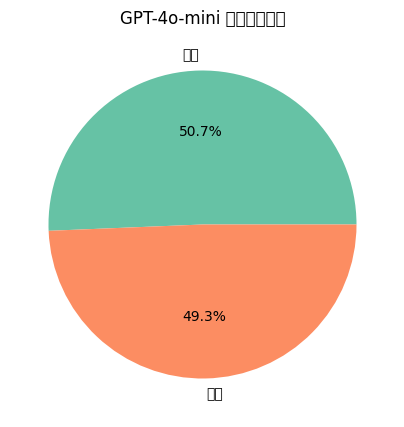


❌ 样例 166
预测: The
この

参考: 2001

理由: The prediction does not provide a valid answer.

❌ 样例 378
预测: TheThe the Sleeperperesakes
参考: automatic motion-sensing doors

理由: The prediction does not match the reference answer.

❌ 样例 186
预测: nan
参考: north america, europe, oceania

理由: The model did not provide an answer.

❌ 样例 502
预测: The percentage of people using Facebook, Twitter, Pinterest, Google+, and LinkedInLinkedIn are the using the age group of of 18-64 using using users?
参考: 9%, 9

理由: The prediction does not provide a valid answer for the percentage of Twitter users in the specified age group.

❌ 样例 242
预测: The is answer percentage of of of worldwide? the countries? Bank and Gaza countries?
参考: 32.6, 32.6%

理由: The prediction does not provide a valid answer.

❌ 样例 257
预测: Theopt
根据文档内容提供的情境和信息,我将为您回答以下问题:

1. 梅拉·马哈德维·德维·马哈德维·德维·马哈德维·德维
参考: gary alexander

理由: The predicted answer does not match the reference answer.

❌ 样例 250
预测: Based on the provided information, Dhನ�onioni to crick

/tmp/ipython-input-183137067.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="word", data=reason_df, palette="viridis")
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38169 (\N{CJK UNIFIED IDEOGRAPH-9519}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22

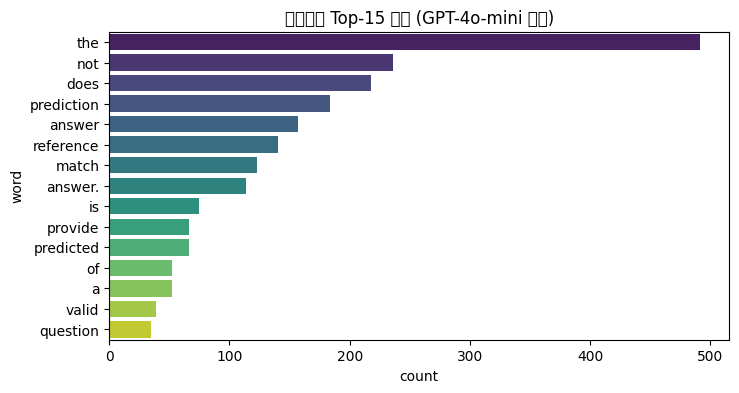

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取结果文件
df = pd.read_csv("infovqa_gpt4omini_judge.csv")
print("总数:", len(df))
print("平均准确率:", df["judge_score"].mean())

# =======================
# 1) 基本统计
# =======================
acc = df["judge_score"].mean()
correct = df["judge_score"].sum()
wrong = len(df) - correct
print(f"正确: {correct}, 错误: {wrong}, Accuracy: {acc:.4f}")

# =======================
# 2) 准确率饼图
# =======================
plt.figure(figsize=(5,5))
plt.pie([correct, wrong],
        labels=["正确","错误"],
        autopct="%.1f%%",
        colors=["#66c2a5","#fc8d62"])
plt.title("GPT-4o-mini 评审结果分布")
plt.show()

# =======================
# 3) 错误样例 Top-10
# =======================
df_errors = df[df["judge_score"]==0].sample(10, random_state=42)  # 随机抽10条
for i, row in df_errors.iterrows():
    print(f"\n❌ 样例 {row['idx']}")
    print("预测:", row["prediction"])
    print("参考:", row["reference"])
    print("理由:", row["judge_reason"])

# =======================
# 4) 错误原因词频
# =======================
from collections import Counter
reasons = df[df["judge_score"]==0]["judge_reason"].dropna().tolist()
tokens = [w.lower() for r in reasons for w in str(r).split()]
freq = Counter(tokens).most_common(15)

reason_df = pd.DataFrame(freq, columns=["word","count"])
plt.figure(figsize=(8,4))
sns.barplot(x="count", y="word", data=reason_df, palette="viridis")
plt.title("错误原因 Top-15 词频 (GPT-4o-mini 输出)")
plt.show()


lora llm

In [63]:
import json, pandas as pd

path = "/content/drive/MyDrive/llama_saves/Qwen2-VL-2B/lora/infolastest/generated_predictions.jsonl"

# 读取前几行
rows = []
with open(path, "r", encoding="utf-8") as f:
    for i, line in zip(range(5), f):
        rows.append(json.loads(line))

df_preview = pd.DataFrame(rows)
print("列名:", df_preview.columns.tolist())
display(df_preview.head())


列名: ['prompt', 'predict', 'label']


,prompt,predict,label
0,<|im_start|>system\nYou are a helpful assistan...,"PinterestPinterestPinterest, Pinterest",pinterest\n
1,<|im_start|>system\nYou are a helpful assistan...,"Rest:Restaurants, Interior design, Wedding venues","restaurants, interior design, wedding venues\n"
2,<|im_start|>system\nYou are a helpful assistan...,"Facebook, Instagram","linkedin, facebook\n"
3,<|im_start|>system\nYou are a helpful assistan...,"LinkedIn, LinkedIn\nLinkedIn, LinkedIn",linkedin\n
4,<|im_start|>system\nYou are a helpful assistan...,"Facebook, Facebook","twitter, facebook, facebook, twitter\n"


In [67]:
import time, json
import pandas as pd
from tqdm import tqdm

# ===== 带 Prompt 的评审函数 =====
def ask_judge_with_prompt(prompt, prediction, reference):
    user_prompt = f"""
    Task: Judge an InfoVQA answer.

    Prompt:
    {prompt}

    Model Prediction:
    {prediction}

    Reference Answer(s):
    {reference}

    Decide if prediction is correct (binary).
    """
    resp = client.chat.completions.create(
        model=MODEL,  # "gpt-4o-mini"
        temperature=0,
        messages=[
            {"role": "system", "content": JUDGE_SYSTEM_PROMPT},
            {"role": "user", "content": user_prompt}
        ]
    )
    text = resp.choices[0].message.content.strip()
    try:
        obj = json.loads(text[text.find("{"):text.rfind("}")+1])
        score = obj.get("score", 0)
        reason = obj.get("reason", "")
    except:
        score, reason = 0, "parse error"
    return score, reason

# ===== 批量评审（带限速） =====
results = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        score, reason = ask_judge_with_prompt(
            row["prompt"],
            row["prediction"],   # ✅ 用 prediction
            row["reference"]     # ✅ 用 reference
        )
    except Exception as e:
        print(f"❌ 出错 idx={i}: {e}")
        time.sleep(5)  # 出错时休眠一会再试
        continue

    results.append({
        "idx": i,
        "prompt": row["prompt"],
        "prediction": row["prediction"],   # ✅ 修正
        "reference": row["reference"],     # ✅ 修正
        "judge_score": score,
        "judge_reason": reason
    })

    time.sleep(0.2)  # ✅ 控制速率，避免429限流

# ===== 保存结果 =====
df_judged = pd.DataFrame(results)
df_judged.to_csv("infovqa_gpt4omini_judge_withprompt.csv", index=False)
print("完成，总数:", len(df_judged))




100%|██████████| 535/535 [10:51<00:00,  1.22s/it]

完成，总数: 535


In [68]:
print("列名:", df.columns.tolist())
print(df.head(2))


列名: ['idx', 'prompt', 'prediction', 'reference', 'judge_score', 'judge_reason']
   idx                                             prompt  \
0    0  <|im_start|>system\nYou are a helpful assistan...   
1    1  <|im_start|>system\nYou are a helpful assistan...   

                                          prediction  \
0                                                NaN   
1  The\nHere are the three business types that Pi...   

                                        reference  judge_score  \
0                                     pinterest\n            1   
1  restaurants, interior design, wedding venues\n            1   

                                        judge_reason  
0  The predicted answer matches the reference ans...  
1  All three business types match the reference a...  


In [69]:
from google.colab import files
files.download("infovqa_gpt4omini_judge_withprompt.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [70]:
import pandas as pd
df = pd.read_csv("/content/infovqa_gpt4omini_judge_withprompt.csv")
print("总样本数:", len(df))
print("平均准确率:", df["judge_score"].mean())


总样本数: 535
平均准确率: 0.07102803738317758


In [71]:
import random, json

# 随机抽 5 条（也可以改成 range(5) 看前 5 条）
sample_ids = random.sample(range(len(df)), 5)

for i in sample_ids:
    row = df.iloc[i]
    print("="*60)
    print(f"样本 idx={i}")
    print("预测 (prediction):", row["prediction"])
    print("参考 (reference):", row["reference"])

    # 构造输入
    user_prompt = f"""
    Task: Judge an InfoVQA answer.

    Model Prediction:
    {row['prediction']}

    Reference Answer(s):
    {row['reference']}

    Decide if prediction is correct (binary).
    """
    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        temperature=0,
        messages=[
            {"role":"system", "content": JUDGE_SYSTEM_PROMPT},
            {"role":"user", "content": user_prompt}
        ]
    )
    raw_output = resp.choices[0].message.content.strip()
    print("LLM 原始输出:", raw_output)

    # 尝试解析
    try:
        obj = json.loads(raw_output[raw_output.find("{"):raw_output.rfind("}")+1])
        print("解析结果:", obj)
    except Exception as e:
        print("❌ JSON 解析失败:", e)


样本 idx=138
预测 (prediction): nan
参考 (reference): 49

LLM 原始输出: {
  "score": 0,
  "reason": "Prediction 'nan' is not a valid answer."
}
解析结果: {'score': 0, 'reason': "Prediction 'nan' is not a valid answer."}
样本 idx=501
预测 (prediction): nan
参考 (reference): 37%

LLM 原始输出: {
  "score": 0,
  "reason": "Prediction 'nan' is not a valid answer."
}
解析结果: {'score': 0, 'reason': "Prediction 'nan' is not a valid answer."}
样本 idx=517
预测 (prediction): The percentage of Brit( percentage of of ofons not prefer to leverage Facebook friends to find their dream job?. find answer data?TheTheuser
The percentage of Britons who do not prefer to leverage Facebook friends to find their dream job is
参考 (reference): 57%

LLM 原始输出: {
  "score": 0,
  "reason": "The model prediction does not provide a numerical answer."
}
解析结果: {'score': 0, 'reason': 'The model prediction does not provide a numerical answer.'}
样本 idx=505
预测 (prediction): The percent of of of the age group of 300-49 are linked users?
参考 (reference): 

In [72]:
import re
import pandas as pd
from rapidfuzz import fuzz

# 1) 读取并清洗
df = pd.read_csv("infovqa_gpt4omini_judge_withprompt.csv")  # 或者你新跑的文件
# 如果是原始 predictions 文件：df = pd.read_json("generated_predictions.jsonl", lines=True)

def clean_text(x):
    if pd.isna(x): return ""
    x = str(x).strip()
    # 把常见 'nan' 字串也当空
    if x.lower() in {"nan", "none", "null"}:
        return ""
    return x

df["prediction"] = df["prediction"].map(clean_text)
df["reference"]  = df["reference"].map(lambda s: clean_text(s).rstrip("\\n"))

# 2) 数值与百分比抽取
num_pat = re.compile(r"[-+]?\d+(?:\.\d+)?%?")
def extract_num_or_percent(s: str):
    """返回第一个数字/百分数字符串（如 '57%', '27', '3.5%'），找不到返回空串"""
    m = num_pat.search(s)
    return m.group(0) if m else ""

def normalize_percent_str(s: str):
    """'57%' -> (57.0, True), '57'->(57.0, False), ''->(None, None)"""
    s = s.strip()
    if not s: return (None, None)
    is_pct = s.endswith("%")
    try:
        val = float(s[:-1]) if is_pct else float(s)
        return (val, is_pct)
    except:
        return (None, None)

# 3) 参考答案可能有多个，用逗号/分号切分
def split_refs(ref: str):
    parts = [p.strip() for p in re.split(r"[;,]", ref) if p.strip()]
    return parts if parts else [ref]

# 4) 规则基线：大小写无关 + 模糊匹配 + 数值/百分比容差
def rule_match(pred: str, ref: str, fuzz_thresh=90, pct_tol=0.5):
    p_clean = pred.strip().lower()
    # 完全为空的预测，直接错
    if not p_clean:
        return 0, "empty prediction"

    # 文本模糊匹配（先走文本路径，能过最好）
    for r in split_refs(ref):
        r_clean = r.strip().lower()
        if not r_clean:
            continue
        if p_clean == r_clean:
            return 1, "exact (case-insensitive)"
        if fuzz.partial_ratio(p_clean, r_clean) >= fuzz_thresh:
            return 1, "fuzzy match"

    # 数值/百分比对齐
    p_num_s = extract_num_or_percent(pred)
    if not p_num_s:
        return 0, "no numeric match"
    p_val, p_is_pct = normalize_percent_str(p_num_s)
    if p_val is None:
        return 0, "invalid numeric"

    for r in split_refs(ref):
        r_num_s = extract_num_or_percent(r)
        if not r_num_s:
            continue
        r_val, r_is_pct = normalize_percent_str(r_num_s)
        if r_val is None:
            continue

        # 规则：单位一致优先对比；若一方有 % 一方没有，默认按数值等同对比
        if p_is_pct == r_is_pct:
            if abs(p_val - r_val) <= pct_tol:
                return 1, "numeric within tolerance"
        else:
            if abs(p_val - r_val) <= pct_tol:
                return 1, "numeric equal (unit-agnostic)"

    return 0, "no match"

# 5) 先跑规则基线，看看理论能到多少
rule_scores, rule_reasons = [], []
for _, row in df.iterrows():
    s, why = rule_match(row["prediction"], row["reference"])
    rule_scores.append(s)
    rule_reasons.append(why)
df["rule_score"] = rule_scores
df["rule_reason"] = rule_reasons

print("Rule-based Accuracy:", df["rule_score"].mean())

# 6) 只对“规则判不准的有效样本”再用 LLMJudge（可选）
#    有效样本：prediction 非空
mask_llm = (df["rule_score"] == 0) & (df["prediction"].str.len() > 0)
df_need_llm = df[mask_llm].copy()
print("Need LLM judge on:", len(df_need_llm))

# ====== 如果要继续调用 LLMJudge（带限速），用你之前的 ask_judge_with_prompt，并只传 predict/reference ======
# from time import sleep
# judged_rows = []
# for i, row in df_need_llm.iterrows():
#     score, reason = ask_judge_with_prompt("", row["prediction"], row["reference"])
#     judged_rows.append((i, score, reason))
#     sleep(0.2)
# for i, s, r in judged_rows:
#     df.loc[i, "judge_score_llm"]  = s
#     df.loc[i, "judge_reason_llm"] = r
#
# # 最终融合：优先用 rule_score=1，否则用 LLM 的判定
# df["final_score"] = df["rule_score"].where(df["rule_score"]==1, df.get("judge_score_llm", 0))
# print("Final Accuracy (rule + LLM):", df["final_score"].mean())

# 7) 保存中间结果，方便你定位问题
df.to_csv("infovqa_clean_rulebaseline.csv", index=False)
print("Saved: infovqa_clean_rulebaseline.csv")


Rule-based Accuracy: 0.08785046728971962
Need LLM judge on: 198
Saved: infovqa_clean_rulebaseline.csv


In [73]:
import re, pandas as pd

df = pd.read_csv("infovqa_clean_rulebaseline.csv")

def has_num_or_pct(s):
    return bool(re.search(r"[-+]?\d+(?:\.\d+)?%?", str(s)))

stats = {
    "total": len(df),
    "empty_prediction": (df["prediction"].str.len()==0).sum(),
    "prediction_with_number": df["prediction"].apply(has_num_or_pct).sum(),
    "reference_with_number": df["reference"].apply(has_num_or_pct).sum(),
    "rule_correct": (df["rule_score"]==1).sum(),
    "llm_candidates": ((df["rule_score"]==0) & (df["prediction"].str.len()>0)).sum(),
}
stats, {k: round(v/len(df),3) for k,v in stats.items() if k not in ["total","rule_correct","llm_candidates"]}


({'total': 535,
  'empty_prediction': np.int64(0),
  'prediction_with_number': np.int64(114),
  'reference_with_number': np.int64(297),
  'rule_correct': np.int64(47),
  'llm_candidates': np.int64(198)},
 {'empty_prediction': np.float64(0.0),
  'prediction_with_number': np.float64(0.213),
  'reference_with_number': np.float64(0.555)})